In [1]:
%load_ext autoreload
%autoreload 2

# Large Scale Kernel Models

> _Author:_ Giacomo Turri — [g-turri](https://github.com/g-turri)

In our exploration of the `kooplearn` library, we delve into the utilization of kernel methods for analyzing dynamical systems. Our initial exposure to the library, as discussed in the [getting started](getting_started) example, involved studying the behavior of the _noisy logistic map_ using the {class}`kooplearn.models.Nonlinear` class.

Expanding our investigation, we now turn our attention to two additional classes within the library: {class}`kooplearn.models.Kernel` and {class}`kooplearn.models.NystroemKernel`. These classes leverage kernel methods to effectively model the transfer operator $\mathcal{T}$. Our focus is on comparing the performance of three models implemented in the above classes:

1.   Reduced Rank Regression (RRR) as described in {footcite:t}`Kostic2022`,
2.   Nyström Reduced Rank Regression (Nyström-RRR) as described in {footcite:t}`Meanti2023`,
3.   Randomized Reduced Rank Regression (Randomized-RRR) as described in {footcite:t}`Turri2023`

by investigating the Lorenz-63 System (a.k.a. Lorenz attractor). This model is defined by a system of three coupled ordinary differential equations:

$$
  \begin{align}
  \dot{x} &= \sigma (y - x), \\
  \dot{y} &= x (\rho - z) - y, \\
  \dot{z} &= x y - \beta z
  \end{align}
$$

where:
- $x, y, z$ are the three variables representing the state of the system;
- $t$ is time;
- $\sigma$, $\rho$, and $\beta$ are parameters of the system.

These parameters play crucial roles in determining the behavior of the Lorenz-63 system. In this notebook, we study the "canonical" configuration, employing the parameter values Edward Lorenz originally used in his seminal paper in 1963: $\sigma=10$, $\rho=28$, and $\beta=8/3$. In this configuration, the Lorenz-63 system exhibits a chaotic attractor known as the Lorenz attractor, which is a butterfly-shaped trajectory in state space.

## Setup `kooplearn` + importing dependecies

In [2]:
import importlib

try:
  importlib.import_module('kooplearn')
except ImportError:
  module = 'kooplearn[full]'
  %pip install -q {module}

In [3]:
# Import dependencies
import functools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

In [4]:
# Wrapper function useful for measuring the execution time of functions
# Adapted from https://realpython.com/python-timer/#creating-a-python-timer-decorator
from time import perf_counter

configs = {
    'train_samples': 10000,
    'test_samples': 100,
}

def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = perf_counter()
        value = func(*args, **kwargs)
        toc = perf_counter()
        elapsed_time = toc - tic
        return value, elapsed_time

    return wrapper_timer

## Data Generation
In `kooplearn`, we provide an implementation of the Lorenz-63 system in {class}`kooplearn.datasets.Lorenz63`. With this class, we sample the dataset by setting the initial condition `X0` equal to 1 for the three components, the number of time steps `T` according to the sample sizes defined above.

In [5]:
from kooplearn.datasets import Lorenz63

raw_data = Lorenz63().sample(X0 = np.ones(3), T=configs["train_samples"] + 1000 + configs["test_samples"])
mean = np.mean(raw_data, axis=0)
norm = np.max(np.abs(raw_data), axis=0)
# Data rescaling
data = raw_data - mean
data /= norm

dataset = {
    "train": data[:configs["train_samples"] + 1],
    "test": data[-configs["test_samples"] - 1:],
}

Here, we provide a visualization of the sampled trajectory. The blue and orange lines represent the training and test trajectories, respectively.

In [9]:
dataset['train'].x.values

array([ 0.05200722,  0.05264283,  0.05449311, ..., -0.59089122,
       -0.62000926, -0.64717615], shape=(10001,))

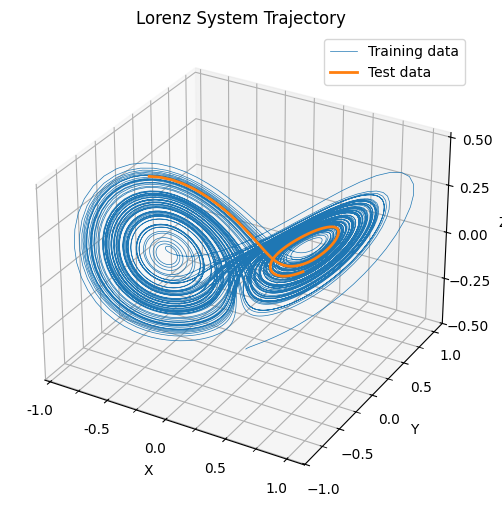

In [10]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(dataset['train'].x.values, dataset['train'].y.values, dataset['train'].z.values, lw=.5, label='Training data')
ax.plot(dataset['test'].x.values, dataset['test'].y.values, dataset['test'].z.values, lw=2, label='Test data')
ax.set_title("Lorenz System Trajectory")
ax.set_xlabel("X")
ax.set_xticks(np.linspace(-1,1,5),)
ax.set_xticklabels(np.linspace(-1,1,5))
ax.set_ylabel("Y")
ax.set_yticks(np.linspace(-1,1,5))
ax.set_zlabel("Z")
ax.set_zticks(np.linspace(-.5,.5,5))

spacing = 0.25
minorLocator = MultipleLocator(spacing)
ax.yaxis.set_minor_locator(minorLocator)
ax.xaxis.set_minor_locator(minorLocator)
ax.grid(which = 'minor')

plt.legend()
plt.show()

## Estimators fitting

Here, we show how to fit the estimators and learn the transfer operator $\mathcal{T}$ in reproducing kernel Hilbert space (RKHS). The first step in training the estimators is the choice of the kernel. In this example, we choose the standard Gaussian kernel and set its length scale using median heuristics.

Then, the hyperparameters to be tuned, common to the three estimators under consideration, are:
- The Tikhonov regularization, `tikhonov_reg`, which should be a small positive number to ensure stability and generalizability,
- The `rank` of the model, which depends on the system being analyzed.

Concerning RRR and Nyström-RRR models we can choose the `svd_solver` to be `full`, computing the exact SVD decomposition with LAPACK sover, or `arnoldi`, exploiting arnoldi iterations with ARPACK solver.

Moreover, for Nyström-RRR model we can set the number of Nyström centers, `num_centers`, where we look for a tradeoff between a fast model to train (small value) and an accurate model (large value).

Finally, in the randomized-RRR model which leverages Gaussian sketching, we can set:
- `iterated_power` *(int)*, the number of power iterations,
- `n_oversamples` *(int)*, the number of oversamples,
- `optimal_sketching` *(bool)*, whether performing optimal sketching or not.

In [11]:
from kooplearn.kernel import KernelRidge, NystroemKernelRidge
from scipy.spatial.distance import pdist
from sklearn.gaussian_process.kernels import RBF

reduced_rank = True
rank = 25
num_centers = 250
tikhonov_reg = 1e-6

# Instantiang the RBF kernel and its length scale as the median of the pairwise distances of the dataset
data_pdist = pdist(dataset['train'])
length_scale = np.median(data_pdist)

In [12]:
def runner(models, stop):
    results = {}
    for name, model in models.items():
        model, fit_time = timer(model.fit)(dataset['train'][:stop])
        # One-step prediction
        X_test, Y_test = model._split_trajectory(dataset['train'])
        X_pred_test = model.predict(X_test)

        results[name] = {
            'fit_time': fit_time,
            'RMSE_onestep_test': np.sqrt(np.mean((X_pred_test - Y_test)**2)),
        }
        print(r'Fitting of {} model took {:.2f}s and has a test RMSE of {:.5f}.'.format(name, results[name]['fit_time'], results[name]['RMSE_onestep_test']))
    return results

We study the performance of the three models in terms of root-mean-square error (RMSE) of the one-step prediction on the test set and of fitting time, as a function of the training sample size.

In [13]:
train_stops = np.logspace(2.5, 3.5, 5).astype(int)

results = []
for stop in train_stops:
    models = {
        'RRR': KernelRidge(n_components=rank, reduced_rank=reduced_rank, kernel='rbf', gamma=length_scale, alpha=tikhonov_reg, eigen_solver='arpack', random_state=0),
        'Randomized-RRR': KernelRidge(n_components=rank, reduced_rank=reduced_rank, kernel='rbf', gamma=length_scale, alpha=tikhonov_reg, eigen_solver='randomized', iterated_power=1, n_oversamples=5, random_state=0),
        'Nystroem-RRR': NystroemKernelRidge(n_components=rank, reduced_rank=reduced_rank, kernel='rbf', gamma=length_scale, alpha=tikhonov_reg, eigen_solver='arpack', n_centers=num_centers, random_state=0), 
    }
    print(f'\nTraining points: {stop}')
    results.append(runner(models, stop))


Training points: 316


/media/gturri/projects/kooplearn/src/kooplearn/kernel/_regressors.py:465: UserWarning: Warning: 10 out of the 25 squared singular values are smaller than the regularization strength 1.00e-06. Consider reducing the regularization strength to avoid overfitting.
  warn(


Fitting of RRR model took 0.45s and has a test RMSE of 0.03857.
Fitting of Randomized-RRR model took 0.09s and has a test RMSE of 0.03857.


/media/gturri/projects/kooplearn/src/kooplearn/kernel/_regressors.py:576: UserWarning: Warning: 10 out of the 25 squared singular values are smaller than the regularization strength 1.00e-06. Consider reducing the regularization strength to avoid overfitting.
  warn(


Fitting of Nystroem-RRR model took 0.29s and has a test RMSE of 0.14612.

Training points: 562


/media/gturri/projects/kooplearn/src/kooplearn/kernel/_regressors.py:465: UserWarning: Warning: 6 out of the 25 squared singular values are smaller than the regularization strength 1.00e-06. Consider reducing the regularization strength to avoid overfitting.
  warn(


Fitting of RRR model took 0.16s and has a test RMSE of 0.03376.
Fitting of Randomized-RRR model took 0.13s and has a test RMSE of 0.03376.


/media/gturri/projects/kooplearn/src/kooplearn/kernel/_regressors.py:576: UserWarning: Warning: 8 out of the 25 squared singular values are smaller than the regularization strength 1.00e-06. Consider reducing the regularization strength to avoid overfitting.
  warn(


Fitting of Nystroem-RRR model took 0.44s and has a test RMSE of 0.11215.

Training points: 1000


/media/gturri/projects/kooplearn/src/kooplearn/kernel/_regressors.py:465: UserWarning: Warning: 2 out of the 25 squared singular values are smaller than the regularization strength 1.00e-06. Consider reducing the regularization strength to avoid overfitting.
  warn(


Fitting of RRR model took 0.43s and has a test RMSE of 0.02100.
Fitting of Randomized-RRR model took 0.29s and has a test RMSE of 0.02100.


/media/gturri/projects/kooplearn/src/kooplearn/kernel/_regressors.py:576: UserWarning: Warning: 4 out of the 25 squared singular values are smaller than the regularization strength 1.00e-06. Consider reducing the regularization strength to avoid overfitting.
  warn(


Fitting of Nystroem-RRR model took 0.37s and has a test RMSE of 0.02748.

Training points: 1778


/media/gturri/projects/kooplearn/src/kooplearn/kernel/_regressors.py:465: UserWarning: Warning: 1 out of the 25 squared singular values are smaller than the regularization strength 1.00e-06. Consider reducing the regularization strength to avoid overfitting.
  warn(


Fitting of RRR model took 0.91s and has a test RMSE of 0.02093.
Fitting of Randomized-RRR model took 0.43s and has a test RMSE of 0.02093.


/media/gturri/projects/kooplearn/src/kooplearn/kernel/_regressors.py:576: UserWarning: Warning: 4 out of the 25 squared singular values are smaller than the regularization strength 1.00e-06. Consider reducing the regularization strength to avoid overfitting.
  warn(


Fitting of Nystroem-RRR model took 0.39s and has a test RMSE of 0.02324.

Training points: 3162


/media/gturri/projects/kooplearn/src/kooplearn/kernel/_regressors.py:465: UserWarning: Warning: 3 out of the 25 squared singular values are smaller than the regularization strength 1.00e-06. Consider reducing the regularization strength to avoid overfitting.
  warn(


Fitting of RRR model took 2.46s and has a test RMSE of 0.02093.
Fitting of Randomized-RRR model took 0.80s and has a test RMSE of 0.02093.
Fitting of Nystroem-RRR model took 0.59s and has a test RMSE of 0.02427.


/media/gturri/projects/kooplearn/src/kooplearn/kernel/_regressors.py:576: UserWarning: Warning: 5 out of the 25 squared singular values are smaller than the regularization strength 1.00e-06. Consider reducing the regularization strength to avoid overfitting.
  warn(


In [14]:
timings = {name: np.array([res[name]['fit_time'] for res in results]) for name in models.keys()}
test_rMSE = {name: np.array([res[name]['RMSE_onestep_test'] for res in results]) for name in models.keys()}

speedup = {}
for name in models.keys():  
    speedup[name] = timings['RRR']/timings[name]

We compare, on the left panel, the RMSE of the one-step prediction on the test set and, on the right panel, the fitting time of the three models. We can observe how the RMSE of the three the models is close to each other and decreases as the number of training points increases. Notably, with randomized-RRR and Nyström-RRR we achieve almost the same RMSE with a speed-up in the fitting time w.r.t. "vanilla" RRR.

Average fitting time speed-up for RRR: 1.00x
Average fitting time speed-up for Randomized-RRR: 2.55x
Average fitting time speed-up for Nystroem-RRR: 1.91x


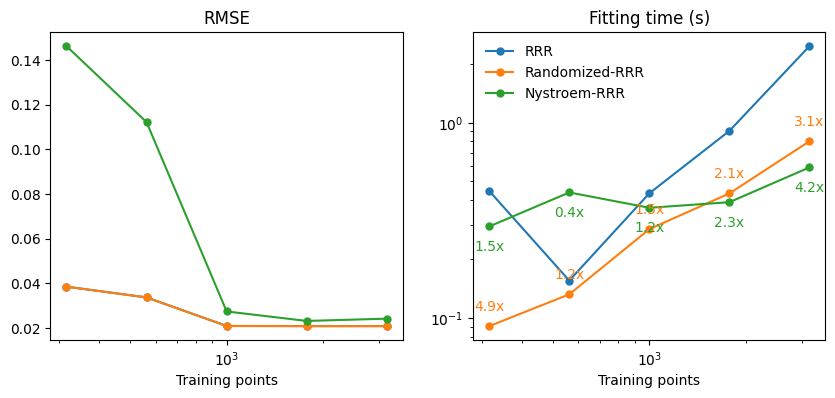

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
for name in models.keys():
    axes[0].plot(train_stops, test_rMSE[name],'.-', label=name, markersize=10)
    axes[1].plot(train_stops, timings[name],'.-', label=name, markersize=10)

colors = []
for line in axes[0].get_lines():
    colors.append(line.get_color())

axes[0].set_title('RMSE')
axes[1].set_title('Fitting time (s)')
axes[1].legend(frameon = False, loc = 'upper left')
axes[1].set_yscale('log')

for ax in axes:
    ax.set_xscale('log')
    ax.set_xlabel('Training points')

ax = axes[1]
for name in models.keys():
    for i, el in enumerate(speedup[name]):
        if (name == 'Randomized-RRR'):
            c = colors[1]
            ax.text(train_stops[i], timings[name][i]*1.2, f'{el:.1f}x', fontsize=10, color = c, ha='center')
        elif (name == 'Nystroem-RRR'):
            c = colors[2]
            ax.text(train_stops[i], timings[name][i]*0.75, f'{el:.1f}x', fontsize=10, color = c, ha='center')
        else:
            pass
    print(f"Average fitting time speed-up for {name}: {np.mean(speedup[name]):.2f}x")

In [9]:
# Testing TimeDelayEmbedding
from kooplearn.utils import TimeDelayEmbedding

embedder = TimeDelayEmbedding(history_length=5)
X_emb = embedder.fit_transform(dataset['train'])
X_rec = embedder.inverse_transform(X_emb)

print(np.allclose(X_rec, dataset['train']))

True


In [11]:
from kooplearn.utils import TimeDelayEmbedding

def runner(models, stop):
    results = {}
    for name, model in models.items():
        embedder = TimeDelayEmbedding(history_length=3)
        X = embedder.fit_transform(dataset['train'])
        model, fit_time = timer(model.fit)(X[:stop])
        # One-step prediction
        X_test, Y_test = model._split_trajectory(X)
        X_pred_test = model.predict(X_test)
        X_pred_test = embedder.inverse_transform(X_pred_test)
        Y_test = embedder.inverse_transform(Y_test)

        results[name] = {
            'fit_time': fit_time,
            'RMSE_onestep_test': np.sqrt(np.mean((X_pred_test - Y_test)**2)),
        }
        print(r'Fitting of {} model took {:.2f}s and has a test RMSE of {:.5f}.'.format(name, results[name]['fit_time'], results[name]['RMSE_onestep_test']))
    return results

In [12]:
train_stops = np.logspace(2.5, 3.5, 5).astype(int)

results = []
for stop in train_stops:
    models = {
        'RRR': KernelRidge(n_components=rank, reduced_rank=reduced_rank, kernel='rbf', gamma=length_scale, alpha=tikhonov_reg, eigen_solver='arpack', random_state=0),
        'Randomized-RRR': KernelRidge(n_components=rank, reduced_rank=reduced_rank, kernel='rbf', gamma=length_scale, alpha=tikhonov_reg, eigen_solver='randomized', iterated_power=1, n_oversamples=5, random_state=0),
        'Nystroem-RRR': NystroemKernelRidge(n_components=rank, reduced_rank=reduced_rank, kernel='rbf', gamma=length_scale, alpha=tikhonov_reg, eigen_solver='arpack', n_centers=num_centers, random_state=0), 
    }
    print(f'\nTraining points: {stop}')
    results.append(runner(models, stop))


Training points: 316


/media/gturri/projects/kooplearn/src/kooplearn/kernel/_regressors.py:447: UserWarning: Warning: 4 out of the 25 squared singular values are smaller than the regularization strength 1.00e-06. Consider reducing the regularization strength to avoid overfitting.
  warn(


Fitting of RRR model took 0.14s and has a test RMSE of 0.07342.
Fitting of Randomized-RRR model took 0.12s and has a test RMSE of 0.07342.


/media/gturri/projects/kooplearn/src/kooplearn/kernel/_regressors.py:558: UserWarning: Warning: 6 out of the 25 squared singular values are smaller than the regularization strength 1.00e-06. Consider reducing the regularization strength to avoid overfitting.
  warn(


Fitting of Nystroem-RRR model took 0.35s and has a test RMSE of 0.06893.

Training points: 562
Fitting of RRR model took 0.16s and has a test RMSE of 0.05375.
Fitting of Randomized-RRR model took 0.12s and has a test RMSE of 0.05336.
Fitting of Nystroem-RRR model took 0.37s and has a test RMSE of 0.07022.

Training points: 1000
Fitting of RRR model took 0.43s and has a test RMSE of 0.02166.
Fitting of Randomized-RRR model took 0.30s and has a test RMSE of 0.02178.
Fitting of Nystroem-RRR model took 0.32s and has a test RMSE of 0.02280.

Training points: 1778
Fitting of RRR model took 0.92s and has a test RMSE of 0.02145.
Fitting of Randomized-RRR model took 0.35s and has a test RMSE of 0.02147.
Fitting of Nystroem-RRR model took 0.32s and has a test RMSE of 0.02164.

Training points: 3162
Fitting of RRR model took 2.50s and has a test RMSE of 0.02136.
Fitting of Randomized-RRR model took 0.88s and has a test RMSE of 0.02163.
Fitting of Nystroem-RRR model took 0.39s and has a test RMSE 

In [13]:
timings = {name: np.array([res[name]['fit_time'] for res in results]) for name in models.keys()}
test_rMSE = {name: np.array([res[name]['RMSE_onestep_test'] for res in results]) for name in models.keys()}

speedup = {}
for name in models.keys():  
    speedup[name] = timings['RRR']/timings[name]

Average fitting time speed-up for RRR: 1.00x
Average fitting time speed-up for Randomized-RRR: 1.88x
Average fitting time speed-up for Nystroem-RRR: 2.31x


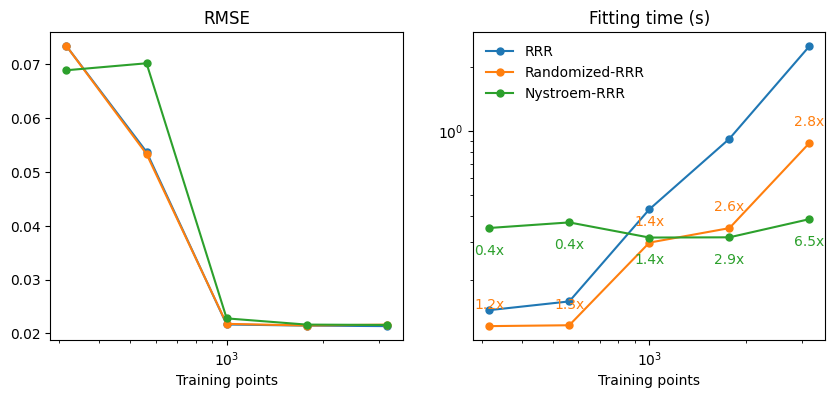

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
for name in models.keys():
    axes[0].plot(train_stops, test_rMSE[name],'.-', label=name, markersize=10)
    axes[1].plot(train_stops, timings[name],'.-', label=name, markersize=10)

colors = []
for line in axes[0].get_lines():
    colors.append(line.get_color())

axes[0].set_title('RMSE')
axes[1].set_title('Fitting time (s)')
axes[1].legend(frameon = False, loc = 'upper left')
axes[1].set_yscale('log')

for ax in axes:
    ax.set_xscale('log')
    ax.set_xlabel('Training points')

ax = axes[1]
for name in models.keys():
    for i, el in enumerate(speedup[name]):
        if (name == 'Randomized-RRR'):
            c = colors[1]
            ax.text(train_stops[i], timings[name][i]*1.2, f'{el:.1f}x', fontsize=10, color = c, ha='center')
        elif (name == 'Nystroem-RRR'):
            c = colors[2]
            ax.text(train_stops[i], timings[name][i]*0.75, f'{el:.1f}x', fontsize=10, color = c, ha='center')
        else:
            pass
    print(f"Average fitting time speed-up for {name}: {np.mean(speedup[name]):.2f}x")